10


In [9]:
import datetime
import logging
import os
os.environ['XLA_NUM_THREADS'] = str(10)
os.environ['XLA_NUM_THREADS']='4' 
os.environ['MKL_NUM_THREADS']='4' 
os.environ['OPENBLAS_NUM_THREADS']='4'

os.environ["NUM_INTER_THREADS"]="4"
os.environ["NUM_INTRA_THREADS"]="4"

os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=True "
                           "intra_op_parallelism_threads=4")
import matplotlib.pyplot as plt
import pandas as pd
from ocean_navigation_simulator.problem_factories.Constructor import (
    Constructor,
)
from ocean_navigation_simulator.problem_factories.SeaweedMissionGenerator import SeaweedMissionGenerator

from ocean_navigation_simulator.utils.misc import set_arena_loggers
# These lines in VSCode to avoid reloading the kernel when changes are made to the external kernel
%load_ext autoreload
%autoreload 2

# Settings for where the problem csv is saved
my_path = os.getcwd()
results_folder = os.path.join(my_path, "tmp/missions/")
os.makedirs(results_folder, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Random Missions

### 1. Arena Configuration and Mission configuration

In [10]:
arena_config = {
    "casadi_cache_dict": {"deg_around_x_t": 2.0, "time_around_x_t": 432000},
    "platform_dict": {
        "battery_cap_in_wh": 400000.0,
        "u_max_in_mps": 0.1,
        "motor_efficiency": 1.0,
        "solar_panel_size": 100,
        "solar_efficiency": 1,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "keep_newest_days": 365,
        "region": "Region 3",
        "hindcast": {
            "field": "OceanCurrents",
            "source": "hindcast_files",
            "source_settings": {
                "folder": "/Users/matthiaskiller/Desktop/data/tmp/hindcast/",
                "source": "HYCOM",
                "type": "hindcast",
            },
        },
        "forecast": None,
        # {
        #     "field": "OceanCurrents",
        #     "source": "longterm_average",
        #     "source_settings": {
        #         "forecast": {
        #             "field": "OceanCurrents",
        #             "source": "forecast_files",
        #             "source_settings": {
        #                 "folder": "/Users/matthiaskiller/Desktop/data/tmp/forecast/",
        #                 "source": "Copernicus",
        #                 "type": "forecast",
        #             },
        #         },
        #         "average": {
        #             "field": "OceanCurrents",
        #             "source": "hindcast_files",
        #             "source_settings": {
        #                 "folder": "/Users/matthiaskiller/Desktop/data/Copernicus/Averages_monthly/",
        #                 "currents": "normal",
        #             },
        #         },
        #     },
        # },
    },
    "solar_dict": {
        "hindcast": { 
            "field": 'SolarIrradiance',
            "source": 'analytical_wo_caching', # can also be analytical_w_caching
            "source_settings": {
                "boundary_buffer": [0.2, 0.2],
                "x_domain": [-180, 180],
                "y_domain": [-90, 90],
                "temporal_domain": 
                ['2020-01-01T00:00:00+00:00','2023-01-10T00:00:00+00:00'
                    # datetime.datetime(year=2020, month=1, day=1, tzinfo=datetime.timezone.utc),
                    # datetime.datetime(year=2023, month=1, day=10, tzinfo=datetime.timezone.utc),
                ],
                "spatial_resolution": 0.1,
                "temporal_resolution": 3600,
            },
        },
        "forecast": None,
    },
    "seaweed_dict": {
        "hindcast": {
            "field": 'SeaweedGrowth',
            "source": 'GEOMAR',
            "source_settings": {
                "filepath": './ocean_navigation_simulator/package_data/nutrients/', #'./data/nutrients/2022_monthly_nutrients_and_temp.nc' 
            },
        },
        "forecast": None,
    },
    "timeout": 3600 * 24 * 90, 
}

# change to this if basic setup works
set_arena_loggers(logging.INFO)
logging.getLogger("SeaweedMissionGenerator").setLevel(logging.INFO)

config = {
    "scenario_config": arena_config,
    "x_range": [-120, -70],
    "y_range": [-20, 20],
    "t_range":
    ["2022-08-01T00:00:00+00:00", "2022-10-05T00:00:00+00:00"
        #datetime.datetime(year=2022, month=7, day=19, tzinfo=datetime.timezone.utc),
        #datetime.datetime(year=2022, month=8, day=20, tzinfo=datetime.timezone.utc),
    ],
    "time_horizon": 7776000, # 3600 * 24 * 90 # in seconds
    "n_samples": 2, # number of start samples per runner
    "min_distance_from_land": 0.5, # degree
}



### 2. Run generation

In [11]:
nb_workers = 1
all_problems = []
for worker in range(nb_workers):
    mission_generator = SeaweedMissionGenerator(
        config=config
        | {
            "seed": 2022 + worker,
            "cache_folder": results_folder + str(worker) + "_",
        }
    )
    problems = mission_generator.generate_batch()
    all_problems.extend(problems)
df = pd.DataFrame([problem.to_dict() for problem in all_problems])
df.to_csv(results_folder + "problems.csv")

INFO:arena.factory:Downloading 67 files to '/Users/matthiaskiller/Desktop/data/tmp/hindcast/'.
  0%|          | 0/67 [00:00<?, ?it/s]INFO:arena.factory:File already downloaded: 'ssh_ts3z_uv3z_ALL-DATA-YEARS-2022-07-31T00:00:00Z-2022-07-31T23:00:00Z.nc', 0.9MB.
INFO:arena.factory:File already downloaded: 'ssh_ts3z_uv3z_ALL-DATA-YEARS-2022-08-01T00:00:00Z-2022-08-01T23:00:00Z.nc', 0.9MB.
INFO:arena.factory:File already downloaded: 'ssh_ts3z_uv3z_ALL-DATA-YEARS-2022-08-02T00:00:00Z-2022-08-02T23:00:00Z.nc', 0.9MB.
INFO:arena.factory:File already downloaded: 'ssh_ts3z_uv3z_ALL-DATA-YEARS-2022-08-03T00:00:00Z-2022-08-03T23:00:00Z.nc', 0.9MB.
INFO:arena.factory:File already downloaded: 'ssh_ts3z_uv3z_ALL-DATA-YEARS-2022-08-04T00:00:00Z-2022-08-04T23:00:00Z.nc', 0.9MB.
INFO:arena.factory:File already downloaded: 'ssh_ts3z_uv3z_ALL-DATA-YEARS-2022-08-05T00:00:00Z-2022-08-05T23:00:00Z.nc', 0.9MB.
INFO:arena.factory:File already downloaded: 'ssh_ts3z_uv3z_ALL-DATA-YEARS-2022-08-06T00:00:00Z-2022

ValueError: Invalid time interval, the time horizon is too large for the given time range

### 3. Visualize generated Navigation Problems

INFO:arena.ocean_field:DataField: Create Hindcast Source (0.8s)
INFO:arena.ocean_field:DataField: Forecast is the same as Hindcast for OceanCurrents.
INFO:arena.solar_field:DataField: Create Hindcast Source (0.0s)
INFO:arena.solar_field:DataField: Forecast is the same as Hindcast for SolarIrradiance.
INFO:arena.seaweed_growth_field:DataField: Create Hindcast Source (12.0s)
INFO:arena.seaweed_growth_field:DataField: Forecast is the same as Hindcast for SeaweedGrowth.
INFO:arena:Arena: Generate Sources (12.8s)
INFO:arena:Arena: Generate Platform (0.0s)
INFO:arena.factory:ArenaFactory: Creating Arena for None (12.82s)
/Users/matthiaskiller/Library/Mobile Documents/com~apple~CloudDocs/Studium/Master RCI/Masters Thesis/Code/OceanPlatformControl/ocean_navigation_simulator/problem_factories/SeaweedMissionGenerator.py:215: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



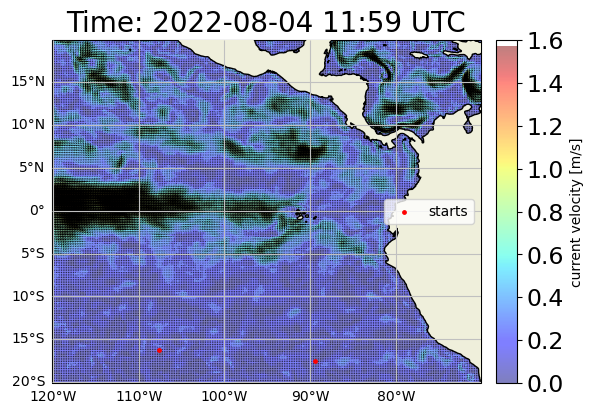

In [16]:
# visualize starts (which defines a c3 "mission") 
SeaweedMissionGenerator.plot_starts(
    problems=all_problems, config=config
)

### 4. To c3 mission

In [ ]:
exp = []
for idx, problem in enumerate(all_problems):
    try:
        exp.append(problem.to_c3_mission_config())
    except BaseException:
        continue

In [ ]:
print(len(exp))

2


## Prepare Simulator for a defined mission

## 1. Base config for controller & observer & navigation

In [12]:
NoObserver = {"observer": None}

# Controller Configs
SeaweedCtrlConfig = {
    "replan_on_new_fmrc": True,
    "replan_every_X_seconds": False,
    "direction": "backward",
    "n_time_vector": 24*90,
    # Note that this is the number of time-intervals, the vector is +1 longer because of init_time
    "deg_around_xt_xT_box_global": 20,  # area over which to run HJ_reachability on the first global run
    "deg_around_xt_xT_box": 1.4,  # area over which to run HJ_reachability
    "accuracy": "high",
    "artificial_dissipation_scheme": "local_local",
    "T_goal_in_seconds": 3600 * 24 * 90,
    "use_geographic_coordinate_system": True,
    "progress_bar": True,
    "grid_res": 0.083,  # Note: this is in deg lat, lon (HYCOM Global is 0.083 and Mexico 0.04)
    "grid_res_global": 0.166, # for first global planning Note: this is in deg lat, lon 
    "d_max": 0.0,
    "calc_opt_traj_after_planning": False,
    "ctrl_name": "ocean_navigation_simulator.controllers.hj_planners.HJBSeaweed2DPlanner.HJBSeaweed2DPlanner"
}


objective_conf = {"type": "max_seaweed"}

## 2. Constructor

In [13]:
import wandb
# choose mission we want to simulate (1 target per mission)
idx_mission = 0
mission_config = exp[idx_mission]

#wandb.init(project="Long Horizon Seaweed Maximization", entity="ocean-platform-control", config=config)


# Step 0: Create Constructor object which contains arena, problem, controller and observer
constructor = Constructor(
    arena_conf=arena_config,
    mission_conf=mission_config,
    objective_conf=objective_conf,
    ctrl_conf=SeaweedCtrlConfig,  # here different controller configs can be put in
    observer_conf=NoObserver,  # here the other observers can also be put int
    download_files=False,
    timeout_in_sec=arena_config["timeout"],
)
# Step 1.1 Retrieve problem
problem = constructor.problem

# Step 1.2: Retrieve arena
arena = constructor.arena
observation = arena.reset(platform_state=problem.start_state)
problem_status = arena.problem_status(problem=problem)





INFO:arena.ocean_field:DataField: Create Hindcast Source (0.8s)
INFO:arena.ocean_field:DataField: Forecast is the same as Hindcast for OceanCurrents.
INFO:arena.solar_field:DataField: Create Hindcast Source (0.0s)
INFO:arena.solar_field:DataField: Forecast is the same as Hindcast for SolarIrradiance.
INFO:arena.seaweed_growth_field:DataField: Create Hindcast Source (12.6s)
INFO:arena.seaweed_growth_field:DataField: Forecast is the same as Hindcast for SeaweedGrowth.
INFO:arena:Arena: Generate Sources (13.5s)
INFO:arena:Arena: Generate Platform (0.0s)
INFO:arena.factory:ArenaFactory: Creating Arena for None (13.49s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (13.3s)


## wandb

In [ ]:
import wandb
wandb.init(project="Long Horizon Seaweed Maximization", entity="ocean-platform-control", name="test_fig")

#### Plot the problem on the map


In [28]:
import matplotlib.pyplot as plt

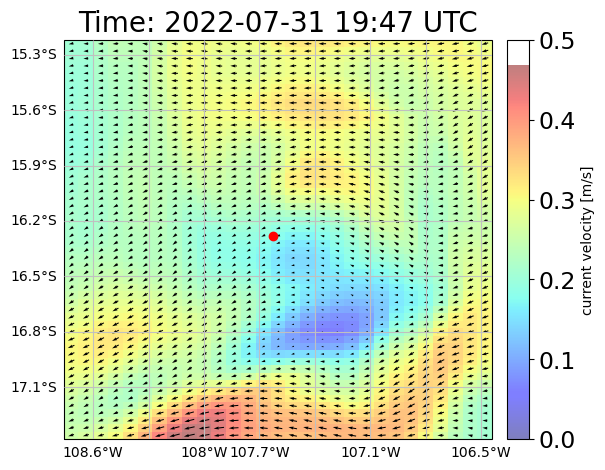

In [29]:
t_interval, lat_bnds, lon_bnds = arena.ocean_field.hindcast_data_source.convert_to_x_y_time_bounds(
    x_0=problem.start_state.to_spatio_temporal_point(), x_T=problem.start_state.to_spatio_temporal_point(),
    deg_around_x0_xT_box=1, temp_horizon_in_s=3600
)

ax = arena.ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)
ax = problem.plot(ax=ax)
fig = ax.get_figure()

fig = plt.figure(fig)

plt.savefig("current_with_start.svg")
plt.savefig("current_with_start.jpg", dpi=80)

wandb.save("current_with_start.svg")

image = wandb.Image("current_with_start.jpg", caption="Current with start")
wandb.log({"Current with start": image})

INFO:arena.seaweed_field.seaweed_growth_source:AnalyticalSource: get Data over Area finished (22.2s)


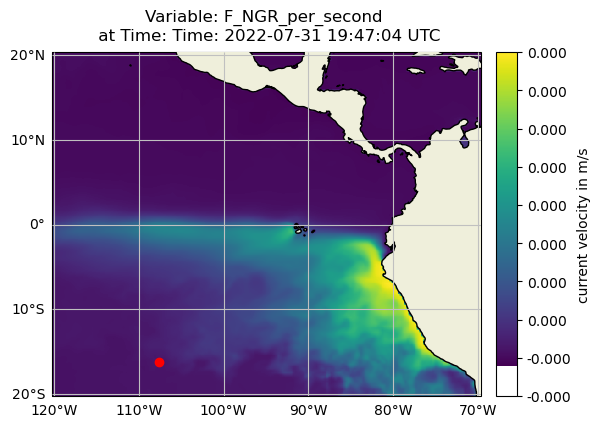

In [30]:
lat_bnds = [-20,20]
lon_bnds = [-120,-70]


ax = arena.seaweed_field.hindcast_data_source.plot_data_at_time_over_area(
    time=problem.start_state.date_time, x_interval=lon_bnds, y_interval=lat_bnds, return_ax=True
)

ax = problem.plot(ax=ax)
fig = ax.get_figure()

fig = plt.figure(fig)

plt.savefig("seaweed_with_start.svg")
plt.savefig("seaweed_with_start.jpg", dpi=80)

wandb.save("seaweed_with_start.svg")

image = wandb.Image("seaweed_with_start.jpg", caption="Seaweed with start")
wandb.log({"Seaweed with start": image})

# 3. Run Planner

In [14]:
# Step 2: Retrieve Controller
# problem.platform_dict = arena.platform.platform_dict
controller = constructor.controller
observer = constructor.observer
observer.observe(observation)
observation.forecast_data_source = observer
# Reachability snapshot plot
action = controller.get_action(observation=observation)
# controller.plot_reachability_snapshot(
#     rel_time_in_seconds=0,
#     granularity_in_h=5,
#     alpha_color=1,
#     time_to_reach=True,
#     fig_size_inches=(12, 12),
#     plot_in_h=True,
#     return_ax=True,
# )
# plt.show()
# Step 3: Retrieve observer


INFO:arena.controller:HJPlannerBase: Planning because of new forecast (Old: None, New: 0)


### 3. Run closed-loop simulation

In [11]:
# Step 4: Run closed-loop simulation
while problem_status==0:
    # Get action
    action = controller.get_action(observation=observation)
    # execute action
    observation = arena.step(action)
    # Observer data assimilation
    observer.observe(observation)
    observation.forecast_data_source = observer

    # update problem status
    problem_status = arena.problem_status(problem=problem)

print("terminated because:", arena.problem_status_text(arena.problem_status(problem=problem)))

INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (0.6s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (0.6s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (0.6s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (0.6s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (0.6s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (0.6s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Platform: Update Casadi + Dynamics (0.6s)
INFO:arena.platform:Platform: Set Dynamics F_x_next Function (0.1s)
INFO:arena.platform:Pl

terminated because: Timeout


INFO:arena.seaweed_field.seaweed_growth_source:AnalyticalSource: get Data over Area finished (0.2s)


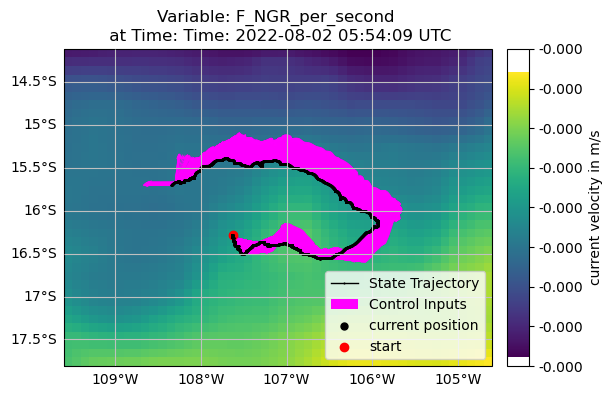

In [12]:
ax = arena.plot_all_on_map(problem=problem, background="seaweed",return_ax=True)
fig = ax.get_figure()
fig = plt.figure(fig)

### 4. Get metrics

INFO:arena.seaweed_field.seaweed_growth_source:AnalyticalSource: get Data over Area finished (0.1s)


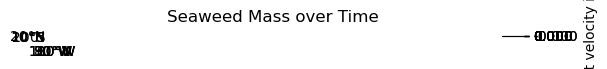

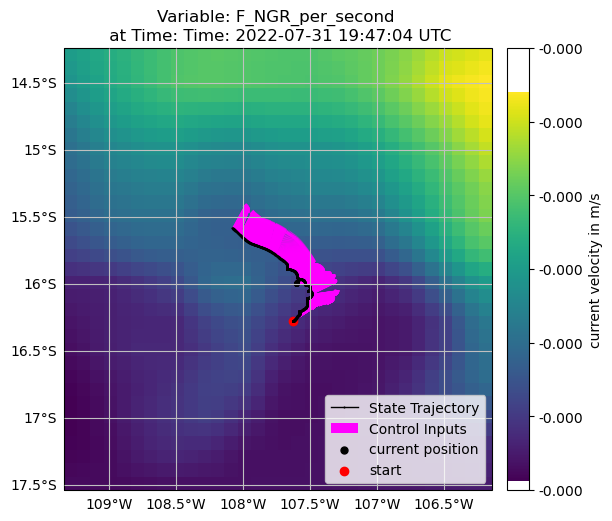

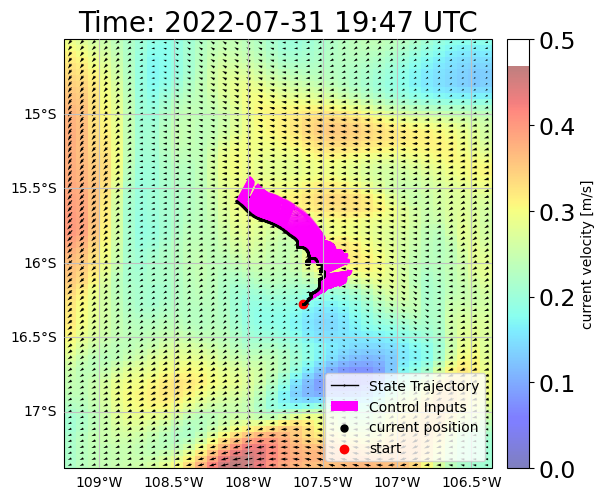

In [ ]:
#print(arena.platform.state.seaweed_mass.kg)
#fig, ax = plt.subplots()
ax = arena.plot_seaweed_trajectory_on_timeaxis(ax=ax)
fig = ax.get_figure()

fig = plt.figure(fig)

plt.savefig("seaweed_trajectory_on_timeaxis.svg")
plt.savefig("seaweed_trajectory_on_timeaxis.jpg", dpi=80)

wandb.save("seaweed_trajectory_on_timeaxis.svg")

image = wandb.Image("seaweed_trajectory_on_timeaxis.jpg", caption="Seaweed trajectory on timeaxis")
wandb.log({"Seaweed trajectory on timeaxis": image})


ax = arena.plot_all_on_map(problem=problem, background="seaweed",return_ax=True)
fig = ax.get_figure()
fig = plt.figure(fig)

plt.savefig("seaweed_trajectory_on_map.svg")
plt.savefig("seaweed_trajectory_on_map.jpg", dpi=80)

wandb.save("seaweed_trajectory_on_map.svg")

image = wandb.Image("seaweed_trajectory_on_map.jpg", caption="Seaweed trajectory on map")
wandb.log({"Seaweed trajectory on map": image})



ax = arena.plot_all_on_map(problem=problem, background="current",return_ax=True)
fig = ax.get_figure()
fig = plt.figure(fig)

plt.savefig("current_trajectory_on_map.svg")
plt.savefig("current_trajectory_on_map.jpg", dpi=80)

wandb.save("current_trajectory_on_map.svg")

image = wandb.Image("current_trajectory_on_map.jpg", caption="Current trajectory on map")
wandb.log({"Current trajectory on map": image})




metrics_folder = f"{results_folder}metrics"

# arena.animate_trajectory(
#     margin=0.25,
#     problem=problem,
#     temporal_resolution=14400,
#     background="current",
#     output=f"{metrics_folder}/platform_trajectories_currents_{idx_mission}.mp4",
#     fps=6,
# )

# arena.animate_trajectory(
#     margin=0.25,
#     problem=problem,
#     temporal_resolution=14400,
#     background="seaweed",
#     output=f"{metrics_folder}/platform_trajectories_seaweed_{idx_mission}.mp4",
#     fps=6,
# )

In [14]:
controller.animate_value_func_3D()

In [15]:
if arena is not None:
    # Create a large dict with all trajectory data
    trajs_dict = {
        "sim_traj": arena.state_trajectory,
        "sim_ctrl": arena.action_trajectory,
    }
    if controller is not None:
        if len(controller.planned_trajs) > 0:
            trajs_dict["plans"] = controller.planned_trajs

In [35]:
wandb.run.summary["trajs_dict"]=trajs_dict

In [36]:
wandb.log(trajs_dict)

In [44]:
trajs_dict["sim_traj"][0]

array([-1.07628697e+02, -1.62803975e+01,  1.65929682e+09,  1.00000000e+02,
        1.00000000e+02,  0.00000000e+00])

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
